<center><h1 style="font-family: cambria;font-size:40px;"> Fourier Transform in MRI:<br> Mathematical theory and related artefacts</h1></center>

In [1]:
# Importing the libraries/functions required to run this notebook

import copy
import utils.fourier_animations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
matplotlib.rc('image', cmap='gray') # Set default image colormap as gray
import numpy as np

from IPython.display import HTML
from numpy.fft import * 

# Introduction

## Who is Joseph Fourier ?

**Jean Baptiste Joseph Fourier** (1768-1830) was a **french mathematician and physicist** that notably investigated the Fourier Series theorem that states that ***any signal can be decomposed into a sum of sinusoidal sub-signals, each having its own frequency, magnitude and phase***. This property later became one of the most fundamental tool for signal processing, especially in Magnetic Resonance Imaging where this duality between the spatial evolution of a signal and its frequency/magnitude/phase components is the bedrock of the image reconstruction process.

<figure><center>
  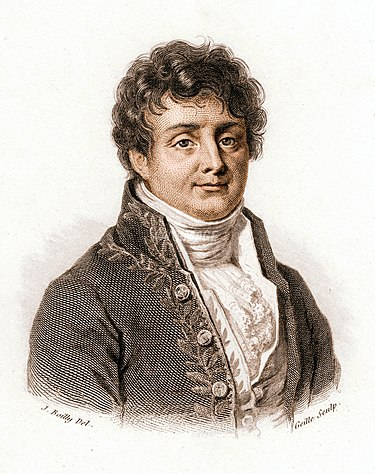
    <figcaption> <i>Joseph Fourier (1768 - 1830)</i> </figcaption></center>
</figure>



Fourier is notably known for: 
- Proposing the **Fourier number** (Heat transfer)
- Discovering the **Fourier series** (Mathematics)
- Proposing the **Fourier Transform** formulas (Mathematics)
- Establishing the **Fourier's law of conduction** (Heat transfer)
- Proposing the **Fourier-Motzkin elimination** algorithm (Mathematics)
- Dicscovering the **greenhouse effect** (Heat transfer)

## Fourier series: Everything is sinusoidal!
As previously mentionned, Fourier demonstrated that any signal can be decomposed into a sum of sinusoidal sub-signals, each having its own frequency, magnitude and phase. 

This is illustrated in the animation below with the example of a unit square signal $s(t)$ decomposed in many sinusoids of different frequencies and amplitudes (here, all sinusoids have the same phase): 

<center> $s_{square}(t) = \sum\limits_{n=0}^{\infty}\frac{4}{\pi (2n+1)}\times sin((2n+1)t) $ </center>

In [3]:
square_signal_decomposition = utils.fourier_animations.square_signal_decomposition(15) # Load the animation
HTML(square_signal_decomposition.to_jshtml()) # Display the animation

As we can see on the animation, the more sinusoids we use, the better the square signal is approximated. This means that perfectly aproaching a square signal would require an infinity of sinusoids, which is obviously impossible to reach in practice. But we will later see that we can still get a good approximation with a finite number of sinusoids.

## The Fourier Domain, just another way of seeing things.

The Fourier Domain is a mathematical representation of a signal in terms of **frequency**. It has a magnitude component and a phase component, it is thus a **complex domain**.

Sometimes, the Fourier Domain is referred to as the **k-space** (we will later see why). This is particularly true in the MRI community.

### Fourier transform

The Fourier Transform is a very powerful mathematical tool that allows us to go back and forth between the spatial (or temporal) domain and the frequency domain (Fourier Domain). In other words, it switches between the spatial representation of a signal (i.e. an image), and the frequency/phase representation of the signal. This two representations are equivalent, as they relate to the same signal, but they have different utilities. For example, the Fourier domain will come handy when we need to visualize the main frequencies that compose a signal, in order to filter it for example.

### Continuous  Fourier Transform

For a continuous signal $s$ (infinite number of points), its Fourier transform $S$ will be given by the following formula:

$S(f) = \int\limits_{-\infty}^{\infty}s(t) e^{-i2\pi ft}dt$

Reciprocally, the signal $s$ can be retrieved from $S$ according to the **inverse Fourier Transform** formula:

$s(t) = \int\limits_{-\infty}^{\infty}S(f) e^{i2\pi ft}df$


### Discrete Fourier Transform

For a discrete signal $s$ composed of $N$ samples, a similar formula can be written down as:

$ S(k) = \sum\limits_{n=0}^{N-1} s(n)e^{-i2\pi \frac{k}{N}n}, \hspace{5mm} for \hspace{5mm} 0 \leqslant k \ < N $

The discrete inverse Fourier Transform formula will then be:

$ s(n) = \frac{1}{N}\sum\limits_{k=0}^{N-1} S(k)e^{i2\pi \frac{n}{N}k} $

We can see here that the letter **k** is used as the variable for the discrete Fourier Domain. This is why it is sometimes reffered to as the **k-space**.


The most common algorithm to compute the Fourier Transforms of discrete signals is the [***fast Fourier Transform***](https://en.wikipedia.org/wiki/Fast_Fourier_transform), usually reffered to as **FFT**. Here we will use a Python implementation of this algorithm available in the `numpy.fft` package.

For a real signal $s$, $S$ will be complex, with both magnitude and phase components being of interest for the processing of the signal.

<br><br>

In order to better visualize how all of this works, we will use the example a a signal composed of 3 sinusoids with different amplitudes, frequencies and phases:
<br><br>

<center>$s_1=\sin(\pi t), \hspace{5mm} s_2=\dfrac{\sin(20 \pi  t +\frac{\pi}{2})}{3},\hspace{5mm} s_3 = \dfrac{\sin(5 \pi  t +\pi)}{5}$</center>

In [ ]:
Fs = 100 # Sampling frequency
t_0 = 0 # Sampling starting time
t_max = 5 # Sampling ending time (s)
nb_samples = (t_max - t_0)* Fs # Number of samples (=500)
t = np.linspace(t_0, t_max, nb_samples) # Creation of the temporal vector (duration: 5 s ; sampling frequency: 100Hz)

s1 = np.sin(t * np.pi)                       # Signal s1 --> Amplitude: 1   a.u. ; Frequency: 0.5 Hz ; Phase: 0 rad
s2 = np.sin(20 * t * np.pi + np.pi / 2) / 3  # Signal s2 --> Amplitude: 1/3 a.u. ; Frequency: 10  Hz ; Phase: pi/2 rad
s3 = np.sin(5 * t * np.pi + np.pi) / 5       # Signal s3 --> Amplitude: 1/5 a.u. ; Frequency: 2.5 Hz ; Phase: pi rad
s = s1+s2+s3 # Signal s (sum of all signals above)

plt.figure(figsize=[15,6])
plt.plot(t, s1, '--'); plt.plot(t, s2, '--'); plt.plot(t, s3, '--'); plt.plot(t, s, lw=3)
plt.title("A 1D sampled signal $s(t)$ composed of 3 sinusoids")
plt.legend(["$s_1(t)$", "$s_2(t)$", "$s_3(t)$", "$s(t) = s_1(t)+s_2(t)+s_3(t)$"])
plt.xlabel("t (s)")
plt.ylabel("Amplitude (u.a.)");
plt.show()

### Magnitude spectrum

The magnitude spectrum represents the signal amplitude associated to every frequencies present in the signal. 

- Low frequencies are represented in the center of the shifted Fourier Domain (and at the beginning of the non-shifted Fourier Domain)
- The highest frequency represented corresponds to the sampling frequency of the signal. 
- The 0 Hz component of the magnitude spectrum represent the mean of the signal (a constant signal will only have one peak at 0Hz),
- If a frequency is not present in the signal, it's magnitude value will simply be null.

In [ ]:
plt.figure(figsize=[16,6])
plt.subplot(121)
plt.plot(np.linspace(0, 2*Fs, nb_samples),np.abs(fft(s)))
plt.title("The FFT $S$ of the signal $s(t)$ (magnitude spectrum)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (a.u.)")

plt.subplot(122)
plt.plot(np.linspace(-Fs, Fs, nb_samples), np.abs(fftshift(fft(s))))
plt.title("Shifted FFT $S$ of the signal $s(t)$ (magnitude spectrum)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (a.u.)")
plt.show()

### Phase spectrum

For any frequency composing the signal, the corresponding phase value will represent the moment the sinusoid was "fired out" compare to a null-phase reference. It this thus very important to know the phase component of the Fourier representation of a signal.

- The phase is usually closely related to the position of the peaks in the signal.

In [ ]:
plt.plot(np.angle(fft(s)))
plt.title('The FFT $S$ of the signal $s(t)$ (phase spectrum)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')

plt.show()

### Nyquist theorem and aliasing

# 2D Fourier transform of images

For 2-dimensionnal $M\times N$ signal (e.g. images), the discrete Fourier Transform formula becomes:

$ S(k, l) = \sum\limits_{m=0}^{M-1}\sum\limits_{n=0}^{N-1} s(m, n)e^{-i2\pi ( \,\frac{mk}{M}+\frac{nl}{N}) \,}, \hspace{5mm} for \hspace{5mm} 0 \leqslant k \ < M,\hspace{5mm} 0 \leqslant l \ < N $

In [ ]:
brain_image = mpimg.imread('brain_MRI.jpg')
brain_FFT = fftshift(fft2(brain_image))
plt.figure(figsize=[15,5])
plt.subplot(131)
plt.imshow(brain_image)
plt.subplot(132)
plt.imshow(np.abs(brain_FFT))
plt.subplot(133)
plt.imshow(np.angle(brain_FFT))
plt.show()

In [ ]:
mask_center = np.zeros_like(brain_FFT)


brain_FFT_center = copy.deepcopy(brain_FFT)
brain_FFT_edges = copy.deepcopy(brain_FFT)
brain_FFT_center[brain_FFT.shape[0]//2-10:brain_FFT.shape[0]//2+10, brain_FFT.shape[1]//2-10:brain_FFT.shape[1]//2+10] = 0
brain_FFT_edges = brain_FFT - brain_FFT_center

plt.figure(figsize=[15,15])
plt.subplot(221)
plt.imshow(np.abs(brain_FFT_center))
plt.subplot(222)
plt.imshow(np.abs(ifft2(ifftshift(brain_FFT_center))))
plt.subplot(223)
plt.imshow(np.abs(brain_FFT_edges))
plt.subplot(224)
plt.imshow(np.abs(ifft2(ifftshift(brain_FFT_edges))))
plt.show()

# Fourier related MRI artefacts

In Magnetic Resonance Images, we use **gradient coils** in order to encode the spatial location of the spins in the Fourier Domain. 

Indeed, the spins rotate arround the main magnetic field $B_0$ of the scanner at a certain frequency $w_0$ (**Larmor Frequency**). The larmor frequency is related to the $B_0$ strength according to the formula below: 
<center>$\omega_0 = \gamma B_0$</center>

This means that, by adding a spatial gradient to the $B_0$ field, the spins' rotation speed will spatially vary, and thus the frequency component of a measured signal will directly be linked to the spatial location of the spins emitting this signal.

## Clipping (RF overflow artifact)

## Spiking

## Fold-Over/wrap-around

## Gibbs artefact (ringing)